# 타이타닉 데이터로 실습

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency

# 1) 데이터 로드 (인터넷 가능할 때)
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# 2) 컬럼 표준화(소문자)
df.columns = df.columns.str.lower()

# 3) 검정에 필요한 핵심 컬럼만
need_cols = ["survived", "fare", "sex", "pclass"]
df = df[need_cols].copy()

# 4) 결측 처리(최소)
df = df.dropna(subset=["survived", "fare", "sex", "pclass"]) # 1이 생존임 

print(df.head())
print(df.isna().sum())


   survived     fare     sex  pclass
0         0   7.2500    male       3
1         1  71.2833  female       1
2         1   7.9250  female       3
3         1  53.1000  female       1
4         0   8.0500    male       3
survived    0
fare        0
sex         0
pclass      0
dtype: int64


## 공통템플릿
- 그룹 플래그 만들기
- 그룹별 생존률/표본수/효과크기 출력
- proportions_ztest(count, nobs)
- 교차표 + chi2_contingency(보조검정)
- 결론 한 문장

## 예제 1 : 요금상위 10% VIP가 생존률이 더높은지 확인한다

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   fare      891 non-null    float64
 2   sex       891 non-null    object 
 3   pclass    891 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 28.0+ KB


In [3]:
# object 이기에 문자열 확인후 형변환진행
df['sex'] = df['sex'].astype('string')

In [4]:
df.describe() # fare가 불안정함. 확인

,survived,fare,pclass
count,891.000000,891.000000,891.000000
mean,0.383838,32.204208,2.308642
std,0.486592,49.693429,0.836071
min,0.000000,0.000000,1.000000
25%,0.000000,7.910400,2.000000
50%,0.000000,14.454200,3.000000
75%,1.000000,31.000000,3.000000
max,1.000000,512.329200,3.000000


<Axes: >

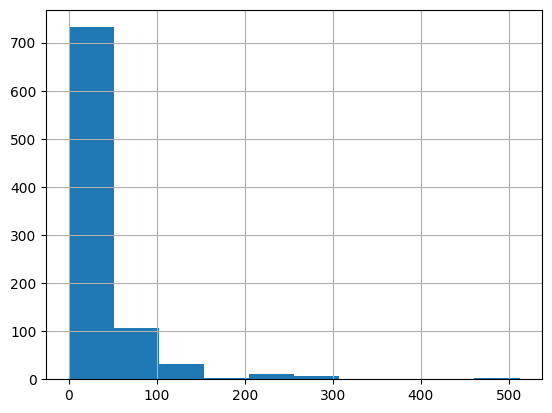

In [5]:
df['fare'].hist()

In [6]:
# df['fare']의 비율확인
df['fare'].quantile([0.75,0.8,0.85,0.90,0.95,0.99,1]) # 0.05단위로 나눠봤을때 0,9 -> 0.95 -> 0.99 가 가장 급격하게 변화가이뤄짐. 따라서 우선 상위 10%를 집단으로잡는것이 맞다 판단.

0.75     31.00000
0.80     39.68750
0.85     56.49580
0.90     77.95830
0.95    112.07915
0.99    249.00622
1.00    512.32920
Name: fare, dtype: float64

### 상위 그룹 나누기 

In [7]:
df['grade'] = df['fare'] > df['fare'].quantile(0.9) # 우선 빠른 연산을 위해 bool로 판단. 
df['grade'].value_counts()

grade
False    804
True      87
Name: count, dtype: int64

### 상위 그룹의 생존률 확인하기

In [8]:
print(f'vip인원 :{len(df[df['grade']==1])}') 

# ⭐️⭐️⭐️⭐️ -> 짜긴했는데 그룹바이는 비효율적
# print(f'vip의 생존률 : \n{df.groupby('grade',as_index=False)['survived'].mean()}') #VIP의 생존률은 0.75

# ⭐️⭐️⭐️⭐️ 실무 (loc,quert사용)
print(f'vip의 생존률 :{df.loc[df['grade']==1,'survived'].mean()}') # 방법 1
print(f'vip의 생존인원 :{df.loc[df['grade']==1,'survived'].sum()}') # 방법 1
df.query("grade == 1")['survived'].mean() # 방법 2 

vip인원 :87
vip의 생존률 :0.7586206896551724
vip의 생존인원 :66


0.7586206896551724

### vip가 아닌그룹의 생존률

In [9]:
print(f'vip가 아닌 인원 :{len(df[df['grade'] != 1])}')
print(f'아닌인원의 생존인원 : {df.query("grade == 0")['survived'].sum()}')
print(f'아닌인원의 생존률 : {df.query("grade == 0")['survived'].mean()}')
# 방법 2 : print(f'아닌인원의 생존률 : {df.loc[df['grade']==0,'survived'].mean()}')

vip가 아닌 인원 :804
아닌인원의 생존인원 : 276
아닌인원의 생존률 : 0.34328358208955223


### 전체적인 생존률 보기

In [10]:
print(f'총인원 : {len(df)}')
print(f'생존률: {df['survived'].mean()}') # 1이 생존이라 mean()이 생존률임

총인원 : 891
생존률: 0.3838383838383838


## 수치상으로는 큰 차이가 존재
- vip 87명: 0.75%
- vip 아닌 사람들 804명 : 0.34%
- 총인원 891명 : 0.38%

## 유의미 한지 검정을 통한 확인 - 두집간간 비교이기에 z-test사용
- 귀무가설 : 돈이 많다고 해서 생존확률이 높은거는 거짓이다. 무의미하다.

In [11]:
from statsmodels.stats.proportion import proportions_ztest

thresh = 0.05

# 🐚 밑내용 직접입력해야하나..? -> 변수사용할거임   이떄 count를 확률로 하는것은 문제가 있지?  -> ㅇㅇ 절대안됌.
count = np.array([66,276])
nobs = np.array([87,804])

z_stat, p_val = proportions_ztest(count,nobs,alternative='two-sided')

if p_val > thresh :
    print(f'귀무가설을 채택해야한다. 유의미 하지않다. 수치:{z_stat} p_value:{p_val}')
else : print(f'귀무가설을 기각해야한다. 유의미 하다. 수치:{z_stat} p_value:{p_val}')

귀무가설을 기각해야한다. 유의미 하다. 수치:7.56707453188342 p_value:3.817229125127529e-14


#### 해당은 가격이 높은그룹 상위 10%를 기준으로 다른 일반 사람들과 비교하엿을때 p-vale가 0.05 이하라서 유의미하다고 볼수있다.
- 보조표 교차표랑 신뢰수준은 어케하지는지 모르겠음.

## 신뢰구간 확인법

In [12]:
from statsmodels.stats.proportion import proportion_confint

# VIP 그룹의 생존율 신뢰구간 (95%)
lower_vip, upper_vip = proportion_confint(count=66, nobs=87, alpha=0.05)
print(f"VIP 생존율 95% CI: {lower_vip:.2f} ~ {upper_vip:.2f}")
# 예상 결과: 0.67 ~ 0.85 (VIP 생존율은 67%에서 85% 사이일 것이다)

# 일반 그룹의 생존율 신뢰구간
lower_norm, upper_norm = proportion_confint(count=276, nobs=804, alpha=0.05)
print(f"일반 생존율 95% CI: {lower_norm:.2f} ~ {upper_norm:.2f}")
# 예상 결과: 0.31 ~ 0.38

# [판단]: 두 구간(0.67~0.85 와 0.31~0.38)이 전혀 겹치지 않지? 
# 그러므로 두 그룹은 확실히 차이가 있다! (p-value < 0.05와 같은 결론)

VIP 생존율 95% CI: 0.67 ~ 0.85
일반 생존율 95% CI: 0.31 ~ 0.38


## 예제 2 : 성별에 따른 생존률 확인
- 여성이 남성보다 더 높은지에 대한

In [13]:
print(f'여성의 수 : {len(df[df['sex']=='female'])}, 생존자수 : {df.query("sex == 'female'")['survived'].sum()}  평균 생존률 : {df.loc[df['sex']=='female','survived'].mean()}')
print(f'남성의 수 : {len(df[df['sex']=='male'])}, 생존자수 : {df.query("sex == 'male'")['survived'].sum()} 평균 생존률 : {df.loc[df['sex']=='male','survived'].mean()}')

여성의 수 : 314, 생존자수 : 233  평균 생존률 : 0.7420382165605095
남성의 수 : 577, 생존자수 : 109 평균 생존률 : 0.18890814558058924


### 가설검정
- 수치상으로는 여성의 생존률이 압도적이지만 이제 올바른지 검정을 통해 증명. 그룹간 비교이기에 z-test진행

In [14]:
from statsmodels.stats.proportion import proportions_ztest

thresh =0.05
count = np.array([233,109])
nobs = np.array([314,577])

z_stat,p_val = proportions_ztest(count,nobs)

if p_val > thresh :
    print(f'귀무가설을 채택해야한다. 유의미 하지않다. 수치:{z_stat} p_value:{p_val}')
else : print(f'귀무가설을 기각해야한다. 유의미 하다. 수치:{z_stat} p_value:{p_val}')

귀무가설을 기각해야한다. 유의미 하다. 수치:16.218833930670097 p_value:3.7117477701134797e-59


#### 기술적 수치상에서는 매우 차이가 커서 유의미해 보였으나 z-test결과 p-vale가 0.05 이하라서 유의미하다고 볼수있다.

In [26]:
from statsmodels.stats.proportion import proportion_confint

lower,higher = proportion_confint(count=223,nobs=314,alpha=0.05)
print(f'여자들의 생존 신뢰구간은 {lower:.2f} ~ {higher:.2f}')

lower,higher = proportion_confint(count=109,nobs=577,alpha=0.05)
print(f'남자들의 생존 신뢰구간은 {lower:.2f} ~ {higher:.2f}')

여자들의 생존 신뢰구간은 0.66 ~ 0.76
남자들의 생존 신뢰구간은 0.16 ~ 0.22


## 1등석 Vs 3등석 (좌석등급효과)
- 1등석 생존률이 3등석보다 높은지 확인한다

In [16]:
print(f' 1등석수 : {len(df[df['pclass'] == 1 ])} 1등석의 생존자수 : {df[df['pclass'] == 1 ]['survived'].sum()}, 생존률: {df[df['pclass'] == 1 ]['survived'].mean()}')
print(f' 3등석수 : {len(df[df['pclass'] == 3 ])} 3등석의 생존자수 : {df[df['pclass'] == 3 ]['survived'].sum()}, 생존률: {df[df['pclass'] == 3 ]['survived'].mean()}')

 1등석수 : 216 1등석의 생존자수 : 136, 생존률: 0.6296296296296297
 3등석수 : 491 3등석의 생존자수 : 119, 생존률: 0.24236252545824846


#### 가설검정 : 유의미해 보이나 검정을 통한 확인 진행. 이또한 그룹간 비교라서 z-test진행

In [17]:
from statsmodels.stats.proportion import proportions_ztest

thresh =0.05
count = np.array([136,119])
nobs = np.array([216,491])

stat,p_val = proportions_ztest(count,nobs)

if p_val > thresh :
    print(f'귀무가설을 채택해야한다. 유의미 하지않다. 수치:{z_stat} p_value:{p_val}')
else : print(f'귀무가설을 기각해야한다. 유의미 하다. 수치:{z_stat} p_value:{p_val}')

귀무가설을 기각해야한다. 유의미 하다. 수치:16.218833930670097 p_value:5.2098077803512734e-23


### p-vale가 0.05 이하라서 유의미하다고 볼수있다.

## 돈이 많은 사람일수록 좋은 자리에 앉았을 확률,상관관계 ?

In [18]:
df[['pclass','fare']].corr()
# 약한 음의상관관계가 있다고 볼수있다.
# 🐚 음의 상관관계란?  -> 반비례하는구조임. -> 좌석이 1로갈수록 좋은거인데 가격은 높아질수록 좋아 그러면 음의 상관관계면 영향이 약간 있다는거네

,pclass,fare
pclass,1.0000,-0.5495
fare,-0.5495,1.0000
